In [1]:
DATASET_TYPE = 'dataset_3'
ARCHITECTURE = 'mobilenet_transferLearning'

In [2]:
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam

import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2

import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import seaborn as sns

In [3]:
import splitfolders

source_folder = f'{DATASET_TYPE}'
target_folder = f'{DATASET_TYPE}_splitted'

train_ratio = .7
val_ratio = .15
test_ratio = .15

splitfolders.ratio(source_folder, output=target_folder, seed=1337, ratio=(train_ratio, val_ratio, test_ratio), group_prefix=None, move=False)

Copying files: 18160 files [00:55, 327.87 files/s]


In [4]:
# applying data prepocessing and loading dataset
train_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset_tranform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/train", transform=train_dataset_tranform)
train_length = len(train_dataset)

validate_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/val", transform=test_dataset_tranform)
validate_length = len(validate_dataset)

test_dataset = ImageFolder(f"{DATASET_TYPE}_splitted/test", transform=test_dataset_tranform)
test_length = len(test_dataset)

dataset_classes = train_dataset.classes
print(dataset_classes)

['bacterial spot', 'early blight', 'healthy', 'late blight', 'leaf mold', 'mosaic virus', 'septori', 'spider mite', 'target spot', 'yellow leaf curl']


In [5]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


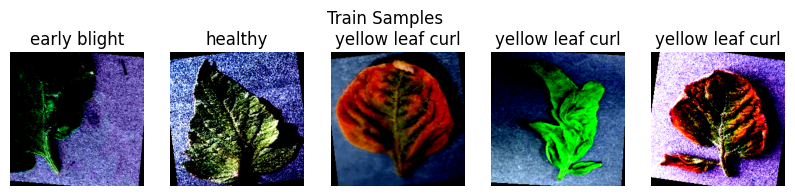

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


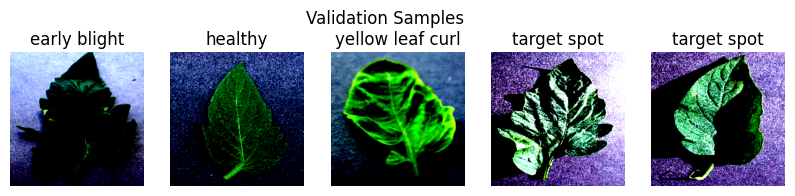

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


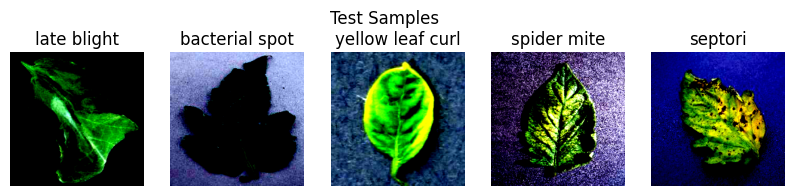

In [6]:
def show_images(loader, title):
    # Get a batch of images and labels from the loader
    images, labels = next(iter(loader))
    images = images.numpy()
    labels = labels.numpy()

    # Plot the images
    plt.figure(figsize=(10, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(np.transpose(images[i], (1, 2, 0)))
        plt.title(f'{dataset_classes[labels[i]]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Display sample images from train loader
show_images(train_loader, 'Train Samples')

# Display sample images from validation loader
show_images(validate_loader, 'Validation Samples')

# Display sample images from test loader
show_images(test_loader, 'Test Samples')

In [7]:
# setting up the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
# modifying architecture output classes
class MobileNetV2(nn.Module):
  def __init__(self, num_of_classes):
    super(MobileNetV2, self).__init__()
    self.model = mobilenet_v2(weights='IMAGENET1K_V1')
    features = self.model.classifier[-1].in_features
    self.model.classifier[-1] = nn.Linear(features, num_of_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [9]:
learning_rate = 0.001
epochs = 15

model = MobileNetV2(num_of_classes=len(dataset_classes))
model = model.to(device)
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_function = CrossEntropyLoss()

print(model)

MobileNetV2(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size=(1, 

epoch number ---> 1 
training loss: 0.3705  training accuracy: 87.60 %
validation loss: 0.1983  validation accuracy: 93.31 %
best loss obtained: 0.1983
--model saved--
epoch number ---> 2 
training loss: 0.1856  training accuracy: 93.62 %
validation loss: 0.1468  validation accuracy: 95.18 %
best loss obtained: 0.1468
--model saved--
epoch number ---> 3 
training loss: 0.1377  training accuracy: 95.18 %
validation loss: 0.1634  validation accuracy: 94.63 %
epoch number ---> 4 
training loss: 0.1248  training accuracy: 95.78 %
validation loss: 0.0890  validation accuracy: 97.32 %
best loss obtained: 0.0890
--model saved--
epoch number ---> 5 
training loss: 0.1091  training accuracy: 96.24 %
validation loss: 0.1154  validation accuracy: 96.18 %
epoch number ---> 6 
training loss: 0.1021  training accuracy: 96.53 %
validation loss: 0.2361  validation accuracy: 93.12 %
epoch number ---> 7 
training loss: 0.0869  training accuracy: 97.12 %
validation loss: 0.1127  validation accuracy: 96.0

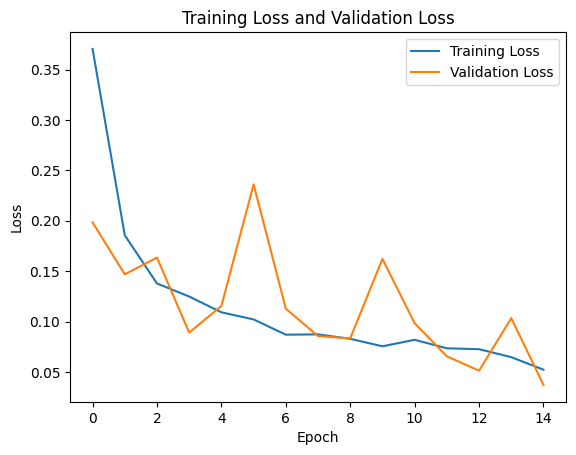

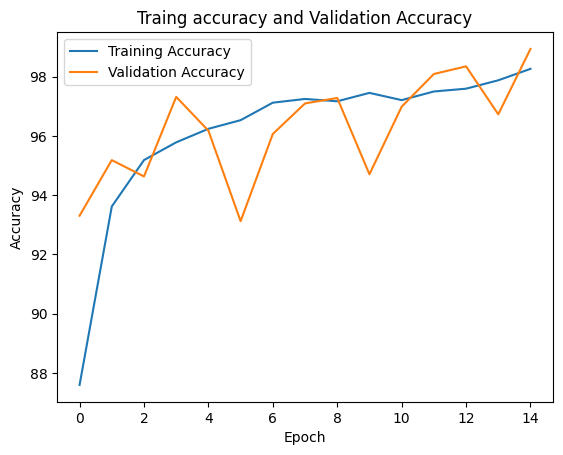

In [10]:
train_losses = []
train_accuracies = []
validate_losses = []
validate_accuracies = []
best_validate_loss = float('inf')
loss_wait_threshold = 5
wait_counter = 0

for epoch in range(epochs):

  print(f"epoch number ---> {epoch + 1} ")

  model.train()
  train_batch_loss = 0.0
  train_correct_predictions = 0
  train_samples = 0
  for xtrain, ytrain in train_loader:

    optimizer.zero_grad()

    xtrain = xtrain.to(device)
    ytrain = ytrain.to(device)
    train_prob = model(xtrain)

    # calculating batch accuracy
    _, train_prediction = torch.max(train_prob, 1)
    train_samples += ytrain.size(0)
    train_correct_predictions += (train_prediction == ytrain).sum().item()

    loss = loss_function(train_prob, ytrain)
    loss.backward()
    optimizer.step()

    # calculating batch loss
    train_batch_loss += loss.item()

  # calculating train loss for epoch
  train_loss = train_batch_loss / len(train_loader)
  train_losses.append(train_loss)

  # calculating train accuracy for epoch
  train_accuracy = 100 * (train_correct_predictions / train_samples)
  train_accuracies.append(train_accuracy)
  print("training loss: {:.4f}  training accuracy: {:.2f} %".format(train_loss, train_accuracy))

  validate_batch_loss = 0.0
  validate_correct_predictions = 0
  validate_samples = 0
  model.eval()
  with torch.no_grad():
    for xvalidate, yvalidate in validate_loader:

      optimizer.zero_grad()

      xvalidate = xvalidate.to(device)
      yvalidate = yvalidate.to(device)
      validate_prob = model(xvalidate)

      #calculating batch accuracy
      _, validate_prediction = torch.max(validate_prob, 1)
      validate_samples += yvalidate.size(0)
      validate_correct_predictions += (validate_prediction == yvalidate).sum().item()

      loss = loss_function(validate_prob, yvalidate)

      #calculating batch loss
      validate_batch_loss += loss.item()

  # calculating validate loss for epoch
  validate_loss = validate_batch_loss / len(validate_loader)
  validate_losses.append(validate_loss)

  # calculating validate accuracy for epoch
  validate_accuracy = 100 * (validate_correct_predictions / validate_samples)
  validate_accuracies.append(validate_accuracy)
  print("validation loss: {:.4f}  validation accuracy: {:.2f} %".format(validate_loss, validate_accuracy))

  if validate_loss < best_validate_loss:
    best_validate_loss = validate_loss
    print("best loss obtained: {:.4f}".format(best_validate_loss))
    torch.save(model.state_dict(), 'best_model_details_tl.pth')
    print(f"--model saved--")
    wait_counter = 0
  else:
    wait_counter += 1
    if wait_counter >= loss_wait_threshold:
      print(f"loss variation exceeded threshold")
      break;

print(f"training and validation for {epochs} epochs completed")
print(f"train losses: {train_losses}")
print(f"train accuracies: {train_accuracies}")
print(f"validation losses: {validate_losses}")
print(f"validation accuracies: {validate_accuracies}")

# saving metrics to a file
np.savez(f'{ARCHITECTURE}_{DATASET_TYPE}_metrics.npz',
         train_losses=train_losses,
         train_accuracies=train_accuracies,
         validate_losses=validate_losses,
         validate_accuracies=validate_accuracies)

plt.plot(train_losses, label='Training Loss')
plt.plot(validate_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss and Validation Loss')
plt.legend()
plt.show()

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validate_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Traing accuracy and Validation Accuracy')
plt.legend()
plt.show()

In [11]:
#loading the saved model

best_model_values = torch.load('best_model_details_tl.pth')
model.load_state_dict(best_model_values)

total_samples = []
total_predictions = []

# testing the model againt test dataset
test_batch_loss = 0.0
test_correct_predictions = 0
test_samples = 0
model.eval()
with torch.no_grad():
  for xtest, ytest in test_loader:
    optimizer.zero_grad()

    xtest = xtest.to(device)
    ytest = ytest.to(device)
    test_prob = model(xtest)

    #calculating batch accuracy
    _, test_prediction = torch.max(test_prob, 1)

    total_samples.extend(ytest.cpu().numpy())
    total_predictions.extend(test_prediction.cpu().numpy())

    test_samples += ytest.size(0)
    test_correct_predictions += (test_prediction == ytest).sum().item()

    loss = loss_function(test_prob, ytest)

    #calculating batch loss
    test_batch_loss += loss.item()

  # calculating validate loss for epoch
  test_loss = test_batch_loss / len(test_loader)

  # calculating validate accuracy for epoch
  test_accuracy = 100 * (test_correct_predictions / test_samples)
  print("test loss: {:.4f}  test accuracy: {:.2f} %".format(test_loss, test_accuracy))

  # saving test metric to file
  np.savez(f'{ARCHITECTURE}_{DATASET_TYPE}_testmetrics.npz',
         total_samples=total_samples,
         total_predictions=total_predictions,
         test_loss=[test_loss],
         test_accuracy=[test_accuracy])

test loss: 0.0483  test accuracy: 98.87 %


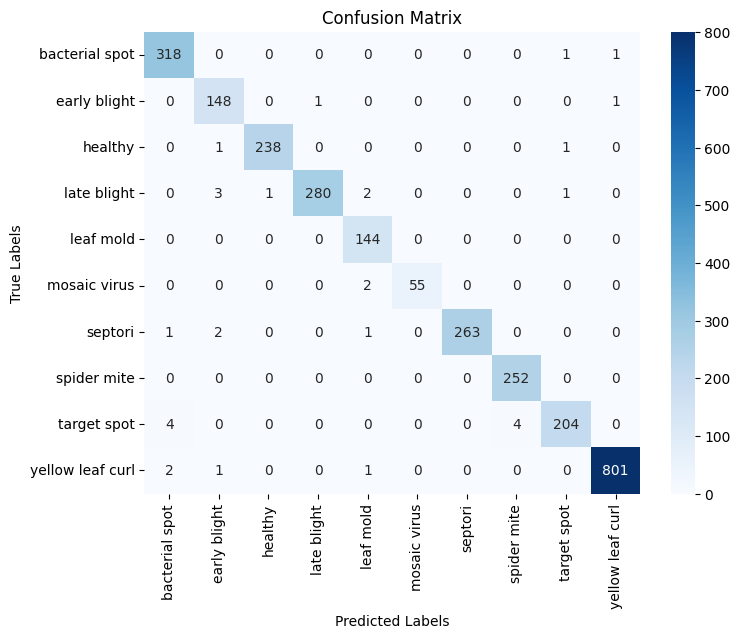

In [12]:
confusion_matrix = confusion_matrix(total_samples, total_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix,
            annot=True,
            cmap='Blues',
            fmt='g',
            xticklabels=dataset_classes,
            yticklabels=dataset_classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [13]:
# Generate the classification report
print(classification_report(total_samples, total_predictions, target_names=dataset_classes))

                  precision    recall  f1-score   support

  bacterial spot       0.98      0.99      0.99       320
    early blight       0.95      0.99      0.97       150
         healthy       1.00      0.99      0.99       240
     late blight       1.00      0.98      0.99       287
       leaf mold       0.96      1.00      0.98       144
    mosaic virus       1.00      0.96      0.98        57
         septori       1.00      0.99      0.99       267
     spider mite       0.98      1.00      0.99       252
     target spot       0.99      0.96      0.97       212
yellow leaf curl       1.00      1.00      1.00       805

        accuracy                           0.99      2734
       macro avg       0.99      0.99      0.99      2734
    weighted avg       0.99      0.99      0.99      2734



In [14]:
# calculating precision, recall, f1-score and accuracy

accuracy = accuracy_score(total_samples, total_predictions)
precision = precision_score(total_samples, total_predictions, average = 'weighted')
recall = recall_score(total_samples, total_predictions, average = 'weighted')
f1score = (2 * precision * recall) / (precision + recall)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1score}")

Accuracy: 0.9886613021214338
Precision: 0.9888562608842552
Recall: 0.9886613021214338
F1-score: 0.9887587718925837
